In [1]:
import argparse
from pathlib import Path
from flax import linen as nn
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# -----------------------------------------------------------------------------#
# Teacher helpers
# -----------------------------------------------------------------------------#
def teacher_forward(x: jnp.ndarray, w1: jnp.ndarray, w2: jnp.ndarray) -> jnp.ndarray:
    """Single‑hidden‑layer linear → erf → linear network (regression)."""
    h = jnp.dot(x, w1) / jnp.sqrt(x.shape[-1])
    # return jnp.dot(jax.scipy.special.erf(h / jnp.sqrt(2.0)), w2)  # shape (N, 1)
    return jnp.dot(nn.relu(h), w2)
    # return jnp.dot(nn.tanh(h), w2)

def corr(f, g):
    f = f - f.mean()
    g = g - g.mean()
    return (f * g).mean() / (f.std() * g.std() + 1e-8)


In [ ]:
d_in=100
d_ht=50
n_samples=10000
v_values=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
bins=200
outdir=None
seed=734


key = random.PRNGKey(seed)
gen_t1_key, x_key, key = random.split(key, 3)
gen_t1_keys = random.split(gen_t1_key, d_ht)
w2_key, key = random.split(key)

# Fixed Gaussian inputs reused across all v
x = random.normal(x_key, (n_samples, d_in))


def generate_teach_ortho(key, dim):
    t_key, r_key = random.split(key)
    t = random.normal(t_key, (dim,))
    t /= jnp.linalg.norm(t) + 1e-8
    r = random.normal(r_key, (dim,))
    proj_r_on_t = (r@t)/(t@t) * t
    ortho_to_t = r - proj_r_on_t
    ortho_to_t /= jnp.linalg.norm(ortho_to_t) + 1e-8
    return t, ortho_to_t

t1_w1, t1_w1_ortho = jax.vmap(generate_teach_ortho, in_axes=(0, None))(gen_t1_keys, d_in)

t_w2 = random.normal(w2_key, (d_ht, 1))

In [45]:
t1_w1.shape
# gen_t1_keys.shape

(50, 100)

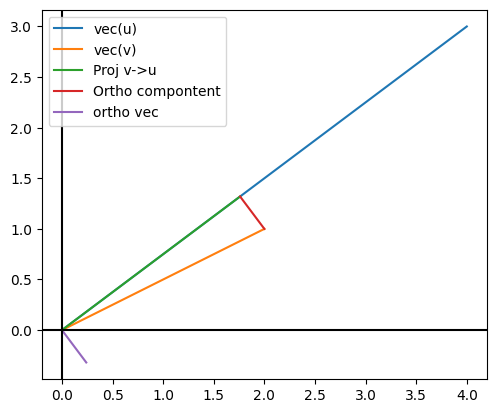

In [6]:
plt.plot([0, 4], [0, 3], label='vec(u)')
plt.plot([0,2], [0,1], label='vec(v)')
plt.plot([0,(44/25)], [0,(33/25)], label='Proj v->u')
plt.plot([(44/25), 2], [(33/25), 1], label='Ortho compontent')
plt.plot([0,(6/25)], [0,(-8/25)], label='ortho vec')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.legend()
plt.show()

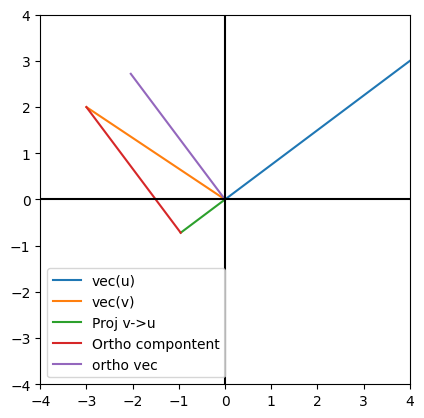

In [7]:
plt.plot([0, 4], [0, 3], label='vec(u)')
plt.plot([0,-3], [0,2], label='vec(v)')
plt.plot([0,(-24/25)], [0,(-18/25)], label='Proj v->u')
plt.plot([(-24/25), -3], [(-18/25), 2], label='Ortho compontent')
plt.plot([0,(-51/25)], [0,(68/25)], label='ortho vec')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
# # Optional: Set consistent x/y limits
limit = 4  # or compute based on your vectors
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.legend()
plt.show()

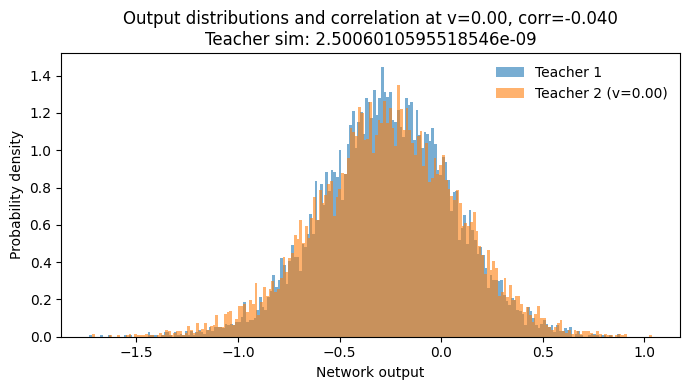

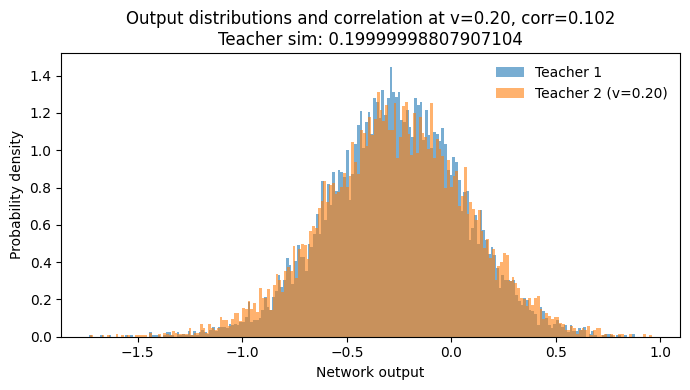

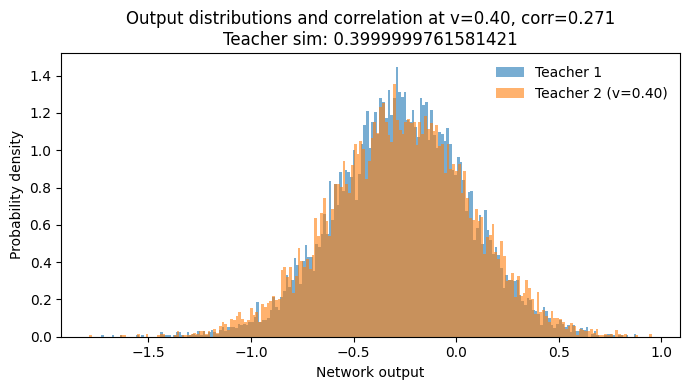

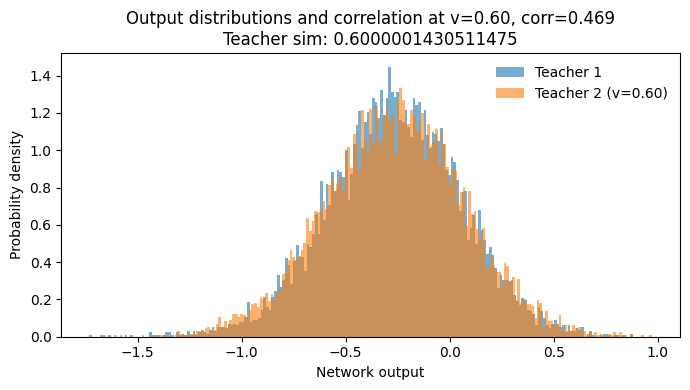

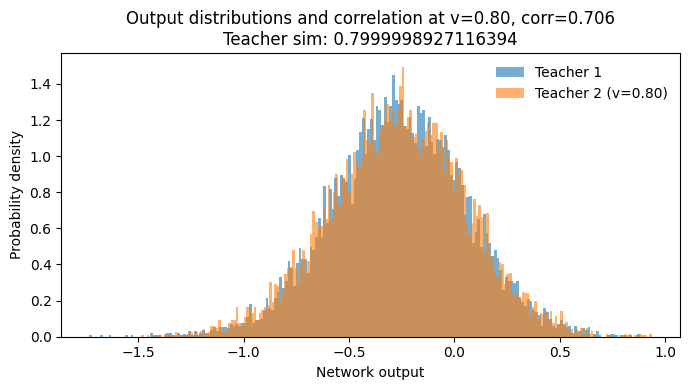

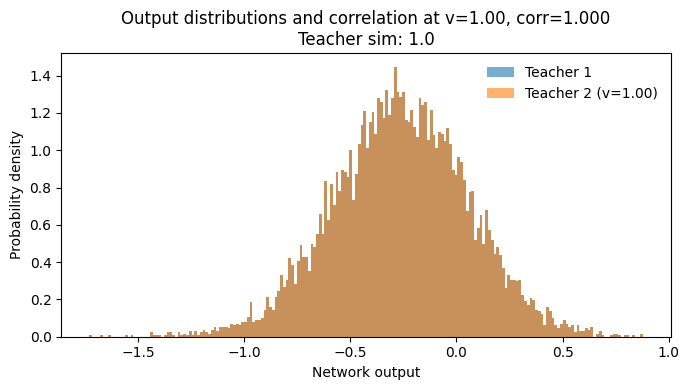

In [43]:
for v in v_values:
    t2_w1 = v*t1_w1 + jnp.sqrt(1-v**2)*t1_w1_ortho
    t2_w1 /= jnp.linalg.norm(t2_w1, axis=1, keepdims=True) + 1e-8

    teacher_similarity = jnp.mean(jnp.sum(t1_w1 * t2_w1, axis=1))

    # Forward passes
    t1_out = teacher_forward(x, t1_w1.T, t_w2).squeeze()
    t2_out = teacher_forward(x, t2_w1.T, t_w2).squeeze()

    c = corr(t1_out, t2_out)

    plt.figure(figsize=(7, 4))
    plt.hist(t1_out, bins=bins, density=True, alpha=0.6, label="Teacher 1")
    plt.hist(t2_out, bins=bins, density=True, alpha=0.6, label=f"Teacher 2 (v={v:.2f})")
    plt.title(f"Output distributions and correlation at v={v:.2f}, corr={c:.3f}\nTeacher sim: {teacher_similarity}")
    plt.xlabel("Network output")
    plt.ylabel("Probability density")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

v=0.0  corr(y1, y2) = 0.991
v=0.2  corr(y1, y2) = 0.993
v=0.4  corr(y1, y2) = 0.995
v=0.6  corr(y1, y2) = 0.996
v=0.8  corr(y1, y2) = 0.998
v=1.0  corr(y1, y2) = 1.000
